## 4.3 门控制单元(GRU)与长短期记忆网络(LSTM)

从本小节开始，我们将开始介绍现代循环神经网络。回顾之前小节的RNN，我们或许会发现存在一些问题：
* 我们在关注一个序列的时候，并不是每个观察值都是同等重要的，同时在RNN当中，太过久远的信息不好抽取出来。我们想只记住相关的观察，如下图所示，我们重点观察的是那只老鼠：
![](https://s2.loli.net/2022/02/07/eFQXAjbTf1PI7v8.png)
* 同时，在一些文本序列当中一些词元没有相关的观测值。 例如，在对网页内容进行情感分析时， 可能有一些辅助HTML代码与网页传达的情绪无关。 我们希望有一些机制来跳过隐状态表示中的此类词元。
* 在序列的各个部分之间存在逻辑中断的时候。 例如，书的章节之间可能会有过渡存在， 或者证券的熊市和牛市之间可能会有过渡存在。 在这种情况下，最好有一种方法来重置我们的内部状态表示。

为了解决上面所提到的一些问题，我们引入两种现代循环神经网络(`GRU`和`LSTM`)来解决。

In [14]:
import torch
from torch import nn
from d2l import torch as d2l

# 读入数据集
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 4.3.1 GRU(门控制单元)
对于想只记住相关的观察，我们可以:
* 能关注的机制（更新门）: update gate
    * 允许我们控制新状态中有多少个是旧状态的副本。
* 能遗忘的机制（重置门）: reset gate
    * 允许我们控制“可能还想记住”的过去状态的数量。

#### 门
更新门和重置门的公式与图示如下:

$$
\begin{aligned}
&\boldsymbol{R}_{t}=\sigma\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x r}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h r}+\boldsymbol{b}_{r}\right) \\
&\boldsymbol{Z}_{t}=\sigma\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x z}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h z}+\boldsymbol{b}_{z}\right)
\end{aligned}
$$

![](https://zh-v2.d2l.ai/_images/gru-1.svg)

#### 候选隐藏状态 (Candidate Hidden State)
用来生成真正的隐藏状态，其公式与图示如下:
$$
\tilde{\boldsymbol{H}}_{t}=\tanh \left(\boldsymbol{X}_{t} \boldsymbol{W}_{x h}+\left(\boldsymbol{R}_{t} \odot \boldsymbol{H}_{t-1}\right) \boldsymbol{W}_{h h}+\boldsymbol{b}_{h}\right)
$$

![](https://zh-v2.d2l.ai/_images/gru-2.svg)


#### 隐状态 (Hidden State)
$$
\boldsymbol{H}_{t}=\boldsymbol{Z}_{t} \odot \boldsymbol{H}_{t-1}+\left(1-Z_{t}\right) \odot \tilde{\boldsymbol{H}}_{t}
$$

![](https://zh-v2.d2l.ai/_images/gru-3.svg)



#### GRU总结
其计算过程与模型架构如下所示:

$$
\begin{aligned}
&\boldsymbol{R}_{t}=\sigma\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x r}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h r}+b_{r}\right) \\
&Z_{t}=\sigma\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x z}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h z}+b_{z}\right) \\
&\tilde{\boldsymbol{H}}_{t}=\tanh \left(\boldsymbol{X}_{t} \boldsymbol{W}_{x h}+\left(\boldsymbol{R}_{t} \odot \boldsymbol{H}_{t-1}\right) \boldsymbol{W}_{h h}+\boldsymbol{b}_{h}\right) \\
&\boldsymbol{H}_{t}=\boldsymbol{Z}_{t} \odot \boldsymbol{H}_{t-1}+\left(1-\boldsymbol{Z}_{t}\right) \odot \tilde{\boldsymbol{H}}_{t}
\end{aligned}
$$

![](https://zh-v2.d2l.ai/_images/gru-3.svg)

#### 代码实践
下面我们通过两种方式进行实践:
* 从零开始实现
* 调用`Pytorch` API。

*注意*:此部分与[4.2](https://github.com/Gary-code/Machine-Learning-Park/tree/main/Part2%20Deep%20Learning%20Practice/4%20%E5%BE%AA%E7%8E%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C/4.2%20%E5%BE%AA%E7%8E%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%85%A5%E9%97%A8)小节内容较为相似，如果代码中遇到不懂的可以回去看[4.2](https://github.com/Gary-code/Machine-Learning-Park/tree/main/Part2%20Deep%20Learning%20Practice/4%20%E5%BE%AA%E7%8E%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C/4.2%20%E5%BE%AA%E7%8E%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%85%A5%E9%97%A8)小节


##### ① 从零开始实现

* 初始化模型参数

从标准差为0.01的高斯分布中提取权重， 并将偏置项设为0，超参数num_hiddens定义隐藏单元的数量， 并且实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。

In [15]:
def get_params(vocab_size, num_hiddens, device):
    """
    初始化模型参数
    :param vocab_size:
    :param num_hiddens:
    :param device:
    :return:
    """
    num_inputs = num_outputs = vocab_size  # 因为是one-hot的

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        """实例化门与候选隐状态参数"""
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

* 定义模型

定义隐状态的初始化函数:

In [16]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

定义门控循环单元模型， 模型的架构与基本的循环神经网络单元是相同的， 只是权重更新公式更为复杂。

In [17]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

* 训练与预测

分别打印输出训练集的困惑度， 以及前缀“time traveler”和“traveler”的预测序列上的困惑度。

perplexity 1.1, 14466.9 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


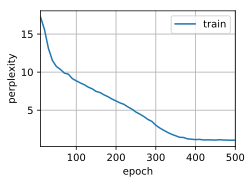

In [18]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

##### ② Pytorch API实现

高级API包含了前文介绍的所有配置细节， 所以我们可以直接实例化门控循环单元模型。

同时下面这段代码的运行速度要快得多， 因为它使用的是编译好的运算符而不是`Python`来处理之前阐述的许多细节, 同时优化了很多大矩阵乘法的细节。

perplexity 1.0, 19320.3 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


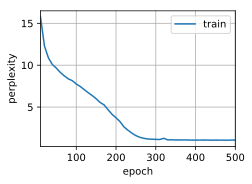

In [19]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### 4.3.2 LSTM(长短期记忆网络)
虽然LSTM放在了GRU的后面来进行介绍，但LSTM的发明远远早于GRU。它是上世纪90年代发明的。

其设计的核心如下:
* 忘记门: 将值朝0减少
* 输入门: 决定不是忽略掉输入数据
* 输出门: 决定是不是使用隐状态

”三门“可用如下公式进行计算:
$$
\begin{aligned}
\boldsymbol{I}_{t} &=\sigma\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x i}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h i}+\boldsymbol{b}_{i}\right) \\
\boldsymbol{F}_{t} &=\sigma\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x f}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h f}+\boldsymbol{b}_{f}\right) \\
\boldsymbol{O}_{t} &=\sigma\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x o}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h o}+\boldsymbol{b}_{o}\right)
\end{aligned}
$$

![](https://zh-v2.d2l.ai/_images/lstm-0.svg)

#### 候选记忆单元
$$
\tilde{\boldsymbol{C}}_{t}=\tanh \left(\boldsymbol{X}_{t} \boldsymbol{W}_{x c}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h c}+\boldsymbol{b}_{c}\right)
$$

![](https://zh-v2.d2l.ai/_images/lstm-2.svg)

#### 隐状态

使其在[-1, 1]之间：

$$
\boldsymbol{H}_{t}=\boldsymbol{O}_{t} \odot \tanh \left(\boldsymbol{C}_{t}\right)
$$

![](https://zh-v2.d2l.ai/_images/lstm-3.svg)

#### 汇总公式
$$
\begin{aligned}
\boldsymbol{I}_{t} &=\sigma\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x i}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h i}+\boldsymbol{b}_{i}\right) \\
\boldsymbol{F}_{t} &=\sigma\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x f}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h f}+\boldsymbol{b}_{f}\right) \\
\boldsymbol{O}_{t} &=\sigma\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x o}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h o}+\boldsymbol{b}_{o}\right) \\
\tilde{\boldsymbol{C}}_{t} &=\tanh \left(\boldsymbol{X}_{t} \boldsymbol{W}_{x c}+\boldsymbol{H}_{t-1} \boldsymbol{W}_{h c}+\boldsymbol{b}_{c}\right) \\
\boldsymbol{C}_{t} &=\boldsymbol{F}_{t} \odot \boldsymbol{C}_{t-1}+\boldsymbol{I}_{t} \odot \tilde{\boldsymbol{C}}_{t} \\
\boldsymbol{H}_{t} &=\boldsymbol{O}_{t} \odot \tanh \left(\boldsymbol{C}_{t}\right)
\end{aligned}
$$

#### 代码实践
* 从零开始
* 简洁实现

##### ①从零开始实现

* 初始化参数

In [20]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

* 模型定义

In [21]:
def init_lstm_state(batch_size, num_hiddens, device):
    """H和C都要初始化，但形状是一样的"""
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [22]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

* 训练与预测

perplexity 1.1, 14874.2 tokens/sec on cpu
time traveller held in his hand was a glitteringmetallin framewo
travelleryou can show black is white bat la gratter the fal


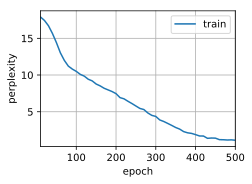

In [24]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

##### ②简洁实现(Pytorch API)

perplexity 1.0, 15515.8 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


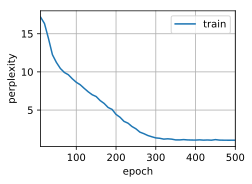

In [25]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)